<h2>Why use Cuda?</h2>
<h5>Cuda perform compute-intensive operations faster by parallelizing tasks across GPUs </h5>

In [4]:
import torch
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(torch.version.cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Is CUDA supported by this system? True
11.8
cuda


<h1>Zero to Mastery Learn PyTorch for Deep Learning </h1>
<a href="https://www.learnpytorch.io/04_pytorch_custom_datasets/">link to source</a>


<h2></h2>

<h2>Data Preparation is paramount</h2>
<h5>Before starting a project or building any kind of model, it's important to know what data you're working with</h5>
<h5>In this case, this is image classification, where we have images in seperate directories titled with a particular class</h5>
<h5>The goal will be to <b>take this data storage structure and turn it into a dataset usable with PyTorch</b></h5>

In [5]:
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "train"

# Check if the image folder does exist
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} does not exist")

data/train directory exists


<h5>We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present</h5>

<h5>Setup our training and testing paths</h5>

In [6]:
train_dir = "data/train"
test_dir = "data/test"
valid_dir = "data/valid/"
train_dir,test_dir,valid_dir

('data/train', 'data/test', 'data/valid/')

<h2>Visualize an image</h2>
<h5>We've seen how our directory structure is formatted. Now in the spirit of the data explorer, it's time to visualize, visualize, visualize!</h5>
<ol>
    <li>Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg</li>
    <li>Pick a random image path using Python's random.choice()</li>
    <li>Get the image class name using pathlib.Path.parent.stem</li>
    <li>And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library)</li>
    <li>We'll then show the image and print some metadata</li>
</ol>


In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)
# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

Random image path: data/train/Basenji/74.jpg
Image class: Basenji
Image height: 224
Image width: 224


<h5>We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first</h5>

(-0.5, 223.5, 223.5, -0.5)

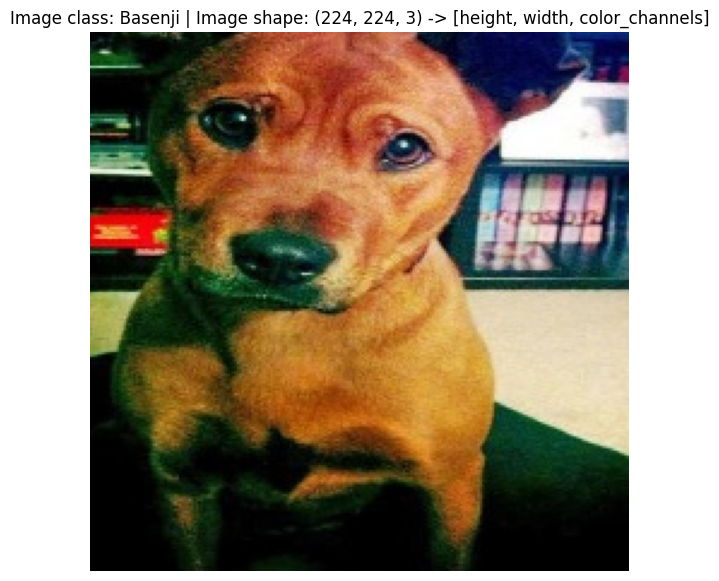

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

<h2>Transforming data</h2>

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with torchvision.transforms

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.
One of the ways we can do this is by using the torchvision.transforms module.


To get experience with torchvision.transforms, let's write a series of transform steps that:

1. Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().


In [10]:
# Write tranforms for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224,224)), # ** More pixels require more computations **
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip,  0.5 = 50% chance
    # Turn the image to a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from from 0 to 255 to be between 0.0 and 1.0 
])

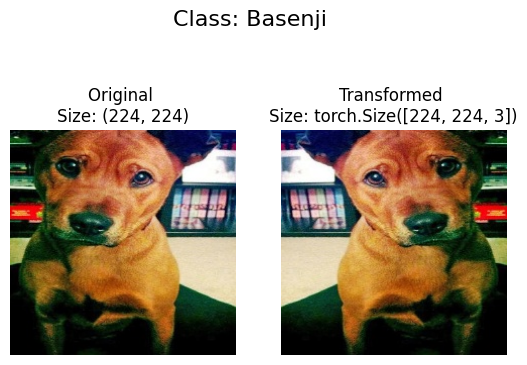

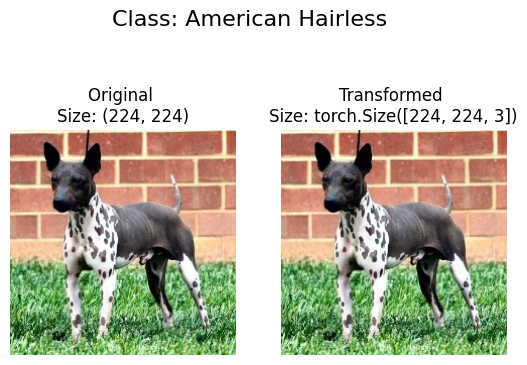

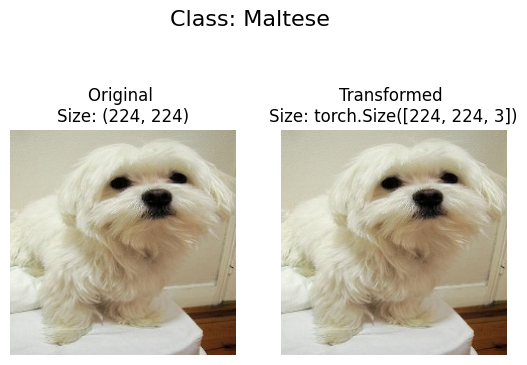

In [11]:
def plot_transformed_image(image_paths, transform, n = 3, seed = 42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_image(image_path_list, transform=data_transform, n=3)

## Loading Image Data Using ImageFolder

Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

In [12]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None # transforms to perform on labels (if necessary)
                                )
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 7946
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 700
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Let's inspect them by checking out the classes and class_to_idx attributes as well as the lengths of our training and test sets.

In [13]:
# Get classes names as list
class_names = train_data.classes
class_names

['Afghan',
 'African Wild Dog',
 'Airedale',
 'American Hairless',
 'American Spaniel',
 'Basenji',
 'Basset',
 'Beagle',
 'Bearded Collie',
 'Bermaise',
 'Bichon Frise',
 'Blenheim',
 'Bloodhound',
 'Bluetick',
 'Border Collie',
 'Borzoi',
 'Boston Terrier',
 'Boxer',
 'Bull Mastiff',
 'Bull Terrier',
 'Bulldog',
 'Cairn',
 'Chihuahua',
 'Chinese Crested',
 'Chow',
 'Clumber',
 'Cockapoo',
 'Cocker',
 'Collie',
 'Corgi',
 'Coyote',
 'Dalmation',
 'Dhole',
 'Dingo',
 'Doberman',
 'Elk Hound',
 'French Bulldog',
 'German Sheperd',
 'Golden Retriever',
 'Great Dane',
 'Great Perenees',
 'Greyhound',
 'Groenendael',
 'Irish Spaniel',
 'Irish Wolfhound',
 'Japanese Spaniel',
 'Komondor',
 'Labradoodle',
 'Labrador',
 'Lhasa',
 'Malinois',
 'Maltese',
 'Mex Hairless',
 'Newfoundland',
 'Pekinese',
 'Pit Bull',
 'Pomeranian',
 'Poodle',
 'Pug',
 'Rhodesian',
 'Rottweiler',
 'Saint Bernard',
 'Schnauzer',
 'Scotch Terrier',
 'Shar_Pei',
 'Shiba Inu',
 'Shih-Tzu',
 'Siberian Husky',
 'Vizsla',

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [15]:
# Check lengths
len(train_data), len(test_data)

(7946, 700)

We can index on our train_data and test_data Dataset's to find samples and their target labels.

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.4784, 0.4667, 0.3922,  ..., 0.3373, 0.3137, 0.2863],
         [0.4353, 0.4431, 0.4235,  ..., 0.3059, 0.2784, 0.2549],
         [0.2902, 0.3294, 0.3843,  ..., 0.2588, 0.2588, 0.2549],
         ...,
         [0.3882, 0.3686, 0.3373,  ..., 0.2784, 0.2745, 0.2824],
         [0.3608, 0.3412, 0.3294,  ..., 0.3020, 0.2824, 0.2745],
         [0.3490, 0.3490, 0.3529,  ..., 0.2510, 0.2392, 0.2431]],

        [[0.5529, 0.5412, 0.4667,  ..., 0.3961, 0.3647, 0.3373],
         [0.5098, 0.5176, 0.4980,  ..., 0.3647, 0.3294, 0.3059],
         [0.3647, 0.4039, 0.4588,  ..., 0.3137, 0.3137, 0.3059],
         ...,
         [0.5098, 0.4902, 0.4588,  ..., 0.3529, 0.3529, 0.3608],
         [0.4824, 0.4627, 0.4510,  ..., 0.3804, 0.3608, 0.3608],
         [0.4706, 0.4706, 0.4745,  ..., 0.3294, 0.3216, 0.3255]],

        [[0.3333, 0.3216, 0.2471,  ..., 0.1647, 0.1529, 0.1255],
         [0.2902, 0.2980, 0.2784,  ..., 0.1490, 0.1216, 0.0980],
         [0.1490, 0.1882, 0.2392,  ..., 0.12

Our images are now in the form of a tensor (with shape [3, 64, 64]) and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

How about we plot a single image tensor using matplotlib?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


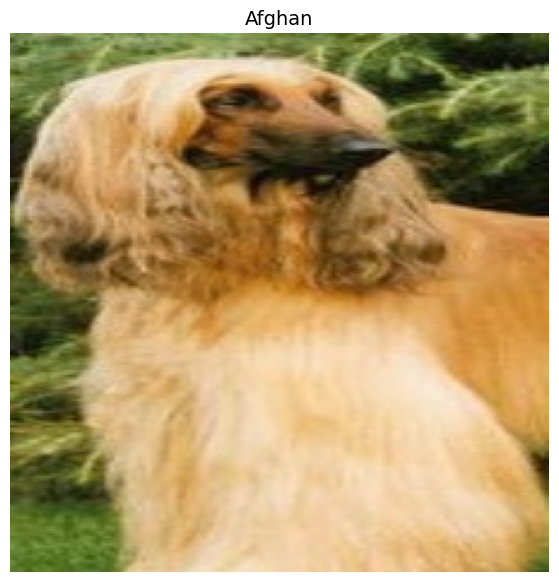

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### Turn loaded images into DataLoader's

We've got our images as PyTorch Dataset's but now let's turn them into DataLoader's.

We'll do so using torch.utils.data.DataLoader.

Turning our Dataset's into DataLoader's makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more  more compute power PyTorch will use to load your data) usually set it to the total number of CPUs on my machine via Python's os.cpu_count()
                              shuffle=True # shuffle the data?
)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False # don't usually need to shuffle testing data
                             )
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f803857add0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f80384ff6a0>)

Now our data is iterable.

Let's try it out and check the shapes.

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the bacth_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### Create TinyVGG model class

Let's build a model - https://www.learnpytorch.io/04_pytorch_custom_datasets/#72-create-tinyvgg-model-class

We'll be using color images instead of grayscale (in_channels=3 instead of in_channels=1 for RGB pixels).

In [20]:
import torch.nn as nn
import torch.nn.functional as F
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(16, 3),
            torch.nn.Dropout(p=0.5)
        ) 
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(p=0.5)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(p=0.5)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(p=0.5)
        )
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(p=0.5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=256 * 2 * 2, #1024
                      out_features=70)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.classifier(x)
        return x

### ResNet Model that we'll use for Transfer Learning

In [21]:
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary

# Weights from pretrained model
weights = ResNet50_Weights.DEFAULT # Default = best aviable weights
model = resnet50(weights=weights).to(device)

# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=model, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(train_data.classes)

# Recreate the classifier layer and seed it to the target device
model.fc = torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True).to(device)


# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 70]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [22]:
# from torchinfo import summary
# summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

### Try a forward pass on a single image (to test the model)

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [23]:
# # 1. Get a batch of images and labels from the DataLoader
# img_batch, label_batch = next(iter(train_dataloader))

# # 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
# img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0].unsqueeze(dim=0)
# print(f"Single image shape: {img_single.shape}\n")

# # 3. Perform a forward pass on a single image
# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(img_single.to(device))

# # 4. Print out what's happening and convert model logits -> pred probs -> pred label
# print(f"Output logits:\n{pred}\n")
# print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_single}")

### Create train & test loop functions

Specifically, we're going to make three functions:

1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

Let's start by building train_step().

In [24]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler
               ):
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0,0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward 
        loss.backward()

        # 5. Optimizer step
        optimizer.step()


        # Calculate and accumalate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    #  
    # scheduler.step()
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Now let's do the same for the `test_step()` function.

The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

But since we'll be doing inference, we'll make sure to turn on the `torch.inference_mode()` context manager for making predictions.

In [25]:
def test_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    
       # Put model in eval mode
       model.eval()

       # Setup test loss and test accuracy values
       test_loss, test_acc = 0, 0

       # Turn on inference context manager
       with torch.inference_mode():
              # Loop through the DataLoader batches
              for batch, (X, y) in enumerate(dataloader):
                     # Send data to target devices
                     X, y = X.to(device), y.to(device)

                     # 1. Forward pass
                     test_pred_logits = model(X)

                     # 2. Calculate and accumulate loss
                     loss = loss_fn(test_pred_logits, y)
                     test_loss += loss.item()

                     # Calculate and accumulate the accuracy 
                     test_pred_labels = test_pred_logits.argmax(dim=1)
                     test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
                     
       # Adjust metrics to get average loss and accuracy per batch 
       test_loss = test_loss / len(dataloader)
       test_acc = test_acc / len(dataloader)
       return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:

1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

In [26]:
from tqdm import tqdm


# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          scheduler: torch.optim = torch.optim.lr_scheduler.StepLR):
    
    # 2. Create a empty dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
     # 4. Print out what's happening
        # if epoch % 10 == 0:
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


### Train and Evaluate Model 0

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of 1e-3 respecitvely.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.

In [27]:
from torch.optim import lr_scheduler

# Set up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 20

# # Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
#                   hidden_units=8, # reduced the number of hidden layers
#                   output_shape=len(train_data.classes)).to(device)

# # Set up the loss function and optimizer 
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=0.0001)
# # optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001, momentum=0.8, weight_decay=0.00001)

# # Start timer
# from timeit import default_timer as timer 
# start_time = timer()

# # Train model_0
# model_0_results = train(model=model_0,
#                         train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader,
#                         optimizer=optimizer,
#                         loss_fn=loss_fn,
#                         epochs=NUM_EPOCHS)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"Total training time: {end_time-start_time:.3f} seconds")


# Use transfer learning 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)
# scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)

# Start timer
from timeit import default_timer as timer 
start_time = timer()
# Setup training and save the results
model_results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                scheduler=None)
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")


  5%|▌         | 1/20 [00:25<08:08, 25.69s/it]

Epoch: 1 | train_loss: 1.7114 | train_acc: 0.7210 | test_loss: 0.6189 | test_acc: 0.9247


 10%|█         | 2/20 [00:50<07:37, 25.40s/it]

Epoch: 2 | train_loss: 0.5018 | train_acc: 0.9062 | test_loss: 0.3502 | test_acc: 0.9403


 15%|█▌        | 3/20 [01:15<07:08, 25.23s/it]

Epoch: 3 | train_loss: 0.3264 | train_acc: 0.9304 | test_loss: 0.2574 | test_acc: 0.9474


 20%|██        | 4/20 [01:40<06:42, 25.16s/it]

Epoch: 4 | train_loss: 0.2427 | train_acc: 0.9485 | test_loss: 0.2066 | test_acc: 0.9545


 25%|██▌       | 5/20 [02:05<06:16, 25.10s/it]

Epoch: 5 | train_loss: 0.1988 | train_acc: 0.9593 | test_loss: 0.1892 | test_acc: 0.9560


 30%|███       | 6/20 [02:30<05:47, 24.83s/it]

Epoch: 6 | train_loss: 0.1677 | train_acc: 0.9658 | test_loss: 0.1847 | test_acc: 0.9574


 35%|███▌      | 7/20 [02:55<05:24, 24.97s/it]

Epoch: 7 | train_loss: 0.1473 | train_acc: 0.9698 | test_loss: 0.1728 | test_acc: 0.9560


 40%|████      | 8/20 [03:20<05:01, 25.13s/it]

Epoch: 8 | train_loss: 0.1214 | train_acc: 0.9776 | test_loss: 0.1591 | test_acc: 0.9616


 45%|████▌     | 9/20 [03:45<04:34, 24.99s/it]

Epoch: 9 | train_loss: 0.1111 | train_acc: 0.9807 | test_loss: 0.1669 | test_acc: 0.9616


 50%|█████     | 10/20 [04:10<04:09, 24.92s/it]

Epoch: 10 | train_loss: 0.0983 | train_acc: 0.9832 | test_loss: 0.1507 | test_acc: 0.9631


 55%|█████▌    | 11/20 [04:35<03:43, 24.86s/it]

Epoch: 11 | train_loss: 0.0916 | train_acc: 0.9828 | test_loss: 0.1623 | test_acc: 0.9489


 60%|██████    | 12/20 [04:59<03:18, 24.85s/it]

Epoch: 12 | train_loss: 0.0839 | train_acc: 0.9885 | test_loss: 0.1386 | test_acc: 0.9688


 65%|██████▌   | 13/20 [05:24<02:53, 24.82s/it]

Epoch: 13 | train_loss: 0.0749 | train_acc: 0.9901 | test_loss: 0.1373 | test_acc: 0.9588


 70%|███████   | 14/20 [05:49<02:28, 24.79s/it]

Epoch: 14 | train_loss: 0.0715 | train_acc: 0.9886 | test_loss: 0.1591 | test_acc: 0.9616


 75%|███████▌  | 15/20 [06:14<02:03, 24.76s/it]

Epoch: 15 | train_loss: 0.0655 | train_acc: 0.9917 | test_loss: 0.1434 | test_acc: 0.9616


 80%|████████  | 16/20 [06:38<01:38, 24.68s/it]

Epoch: 16 | train_loss: 0.0643 | train_acc: 0.9892 | test_loss: 0.1653 | test_acc: 0.9460


 85%|████████▌ | 17/20 [07:03<01:14, 24.71s/it]

Epoch: 17 | train_loss: 0.0590 | train_acc: 0.9920 | test_loss: 0.1517 | test_acc: 0.9588


 90%|█████████ | 18/20 [07:28<00:49, 24.71s/it]

Epoch: 18 | train_loss: 0.0551 | train_acc: 0.9927 | test_loss: 0.1417 | test_acc: 0.9560


 95%|█████████▌| 19/20 [07:53<00:24, 24.77s/it]

Epoch: 19 | train_loss: 0.0563 | train_acc: 0.9927 | test_loss: 0.1410 | test_acc: 0.9489


100%|██████████| 20/20 [08:17<00:00, 24.89s/it]

Epoch: 20 | train_loss: 0.0533 | train_acc: 0.9939 | test_loss: 0.1451 | test_acc: 0.9560
Total training time: 497.802 seconds


### Making predictions
Now we've got a trained model, let's turn on it's evaluation mode and make some predictions.

In [28]:
# Turn model into evaluation mode
model.eval()
# Get a batch of images and labels from the DataLoader
test_img_batch, test_label_batch = next(iter(test_dataloader))
test_img_batch.unsqueeze(dim=0) # unsqueeze the image so its shape fits the model

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model(test_img_batch.to(device))
y_preds

tensor([[ 6.0237, -6.2869, -7.4881,  ..., -7.1727, -6.3644, -8.0996],
        [ 4.8268, -3.7804, -5.5434,  ..., -5.7088, -3.9864, -5.3682],
        [ 6.6011, -4.6028, -7.4893,  ..., -6.1311, -7.5049, -6.2426],
        ...,
        [-5.1480, -6.1362,  6.6092,  ..., -5.6236, -5.3700, -3.5133],
        [-6.1916, -3.1127, -4.5764,  ..., -4.5793, -2.7412, -4.0405],
        [-5.7582, -4.5642, -4.3703,  ..., -5.7744, -2.8981, -4.0906]],
       device='cuda:0')

### Plot the loss curves of Model 0

From the print outs of our model_0 training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**.

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0

In [29]:
# Check the model_0_results keys
# model_0_results.keys()
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [30]:
from typing import List, Dict
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

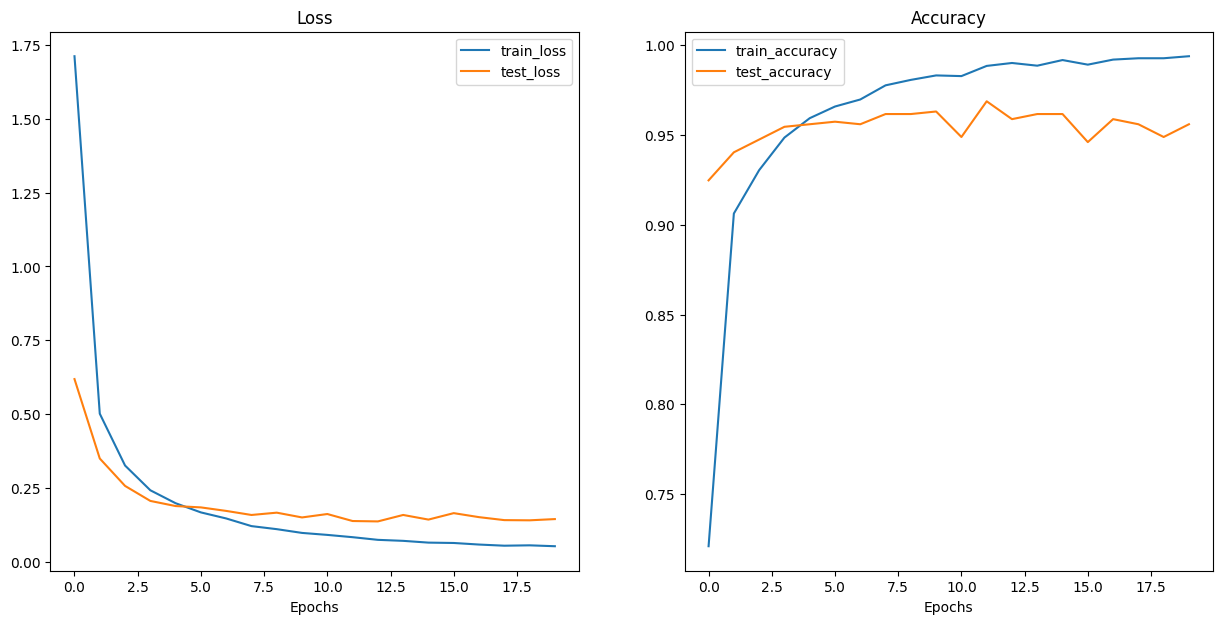

In [31]:
# plot_loss_curves(model_0_results)
plot_loss_curves(model_results)


### What should an ideal loss curve look like
https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

In [32]:
import pandas as pd
# model_0_df = pd.DataFrame(model_0_results)
# model_0_df
model_df = pd.DataFrame(model_results)
model_df

,train_loss,train_acc,test_loss,test_acc
0,1.711446,0.720959,0.618891,0.924716
1,0.501803,0.906250,0.350162,0.940341
2,0.326389,0.930397,0.257409,0.947443
3,0.242652,0.948544,0.206623,0.954545
4,0.198819,0.959337,0.189238,0.955966
5,0.167739,0.965838,0.184701,0.957386
6,0.147283,0.969754,0.172811,0.955966
7,0.121372,0.977636,0.159077,0.961648
8,0.111066,0.980673,0.166881,0.961648
9,0.098337,0.983158,0.150729,0.963068


### Save and load best performing model
- `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
- `torch.load` - a function to load in a saved PyTorch object.
- `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

In [33]:
from pathlib import Path 

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                exist_ok=True # if models directory already exists, don't error
                )

# Create model save path
MODEL_NAME = "dog_breed_image_classification_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f = MODEL_SAVE_PATH
           )

# Create a new instance of model (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = resnet50()
loaded_model.fc = torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True).to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(test_img_batch.to(device))
y_preds == loaded_model_preds

Saving model to: models/dog_breed_image_classification_model.pth
Loaded model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsa

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

### Accuracy by class

In [34]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images.unsqueeze(dim=0) # reduce dimensions to fit model

        outputs = loaded_model(images.to(device)) # must be on the same device
        _,predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count)/ total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: Afghan is 100.0 %
Accuracy for class: African Wild Dog is 100.0 %
Accuracy for class: Airedale is 100.0 %
Accuracy for class: American Hairless is 90.0 %
Accuracy for class: American Spaniel is 80.0 %
Accuracy for class: Basenji is 90.0 %
Accuracy for class: Basset is 100.0 %
Accuracy for class: Beagle is 100.0 %
Accuracy for class: Bearded Collie is 100.0 %
Accuracy for class: Bermaise is 100.0 %
Accuracy for class: Bichon Frise is 100.0 %
Accuracy for class: Blenheim is 90.0 %
Accuracy for class: Bloodhound is 100.0 %
Accuracy for class: Bluetick is 100.0 %
Accuracy for class: Border Collie is 100.0 %
Accuracy for class: Borzoi is 100.0 %
Accuracy for class: Boston Terrier is 50.0 %
Accuracy for class: Boxer is 100.0 %
Accuracy for class: Bull Mastiff is 100.0 %
Accuracy for class: Bull Terrier is 80.0 %
Accuracy for class: Bulldog is 80.0 %
Accuracy for class: Cairn is 90.0 %
Accuracy for class: Chihuahua is 100.0 %
Accuracy for class: Chinese Crested is 90.0 %
A

### Predict and Plot from images in test set
It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

Visualize, visualize, visualize!

In [221]:
from typing import List, Tuple
from PIL import Image
import torchvision

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(
        model: torch.nn.Module,
        image_path: str,
        class_names: List[str],
        image_size: Tuple[int, int] = (224, 224),
        transform: torchvision.transforms = None,
        device: torch.device=device
):
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
        ])

    ### Predict on image ###
        
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    ### Top 3 results ###
    # Use argsort to sort pred labels in descending order and get top 3 from tensor
    top_3_image_pred_labels = torch.argsort(target_image_pred_probs, dim=1, descending=True)

    # Display the top 3 labels
    first_image_pred_label = top_3_image_pred_labels[:,0]
    second_image_pred_label = top_3_image_pred_labels[:,1]
    third_image_pred_label = top_3_image_pred_labels[:,2]

    print(f"Best pred: {class_names[first_image_pred_label]}")
    print(f"Second best pred: {class_names[second_image_pred_label]}")
    print(f"Third best pred: {class_names[third_image_pred_label]}")

    # Use argsort to sort the percentages in descending order than get top 3 percentages from tensor
    top_3_image_pred_probs = torch.argsort(target_image_pred_probs, dim=1, descending=True)
    top_3_image_pred_probs = torch.topk(target_image_pred_probs, 3)

    # Display the top 3 probabilities
    first_image_pred_prob = top_3_image_pred_probs[0][:,0]
    second_image_pred_prob = top_3_image_pred_probs[0][:,1]
    third_image_pred_prob =  top_3_image_pred_probs[0][:,2]
    print(f"Prob: {first_image_pred_prob.max() * 100:.2f} %")
    print(f"Prob: {second_image_pred_prob.max() * 100:.2f} %")
    print(f"Prob: {third_image_pred_prob.max() * 100:.2f} %")
    
    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    # plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max() * 100:.2f} %")
    plt.title(f"Best Pred: {class_names[first_image_pred_label]}  |  Prob: {first_image_pred_prob.max() * 100:.2f} %\n Second Best Pred: {class_names[second_image_pred_label]}  |  Prob: {second_image_pred_prob.max() * 100:.2f} %\n Third Best Pred: {class_names[third_image_pred_label]}  |  Prob:  {third_image_pred_prob.max() * 100:.2f} %")
    plt.axis(False)



Best pred: Corgi
Second best pred: Bull Terrier
Third best pred: Basenji
Prob: 98.63 %
Prob: 0.59 %
Prob: 0.18 %
Best pred: Blenheim
Second best pred: Japanese Spaniel
Third best pred: Cocker
Prob: 99.72 %
Prob: 0.10 %
Prob: 0.07 %
Best pred: Cairn
Second best pred: Scotch Terrier
Third best pred: Yorkie
Prob: 98.21 %
Prob: 0.84 %
Prob: 0.18 %


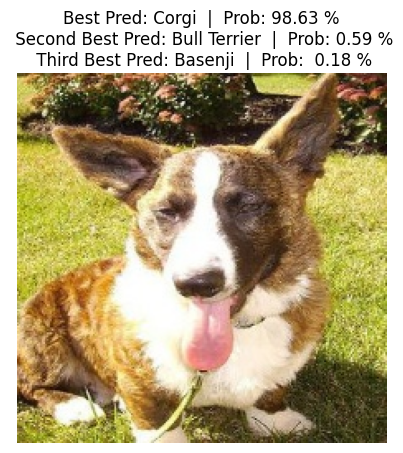

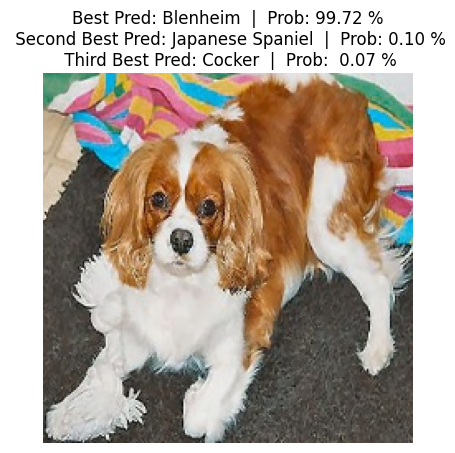

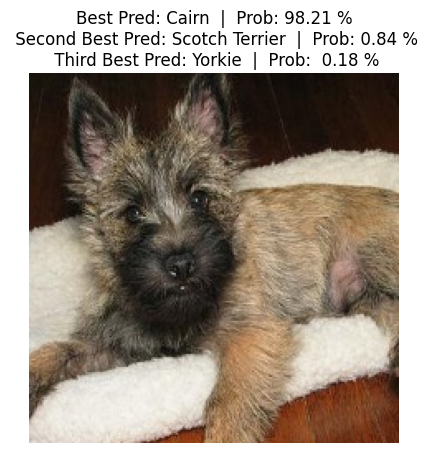

In [224]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=loaded_model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### Test on custom image

data/winston.jpg already exists, skipping download.
Best pred: Pug
Second best pred: Bull Mastiff
Third best pred: Bulldog
Prob: 93.96 %
Prob: 1.93 %
Prob: 1.39 %


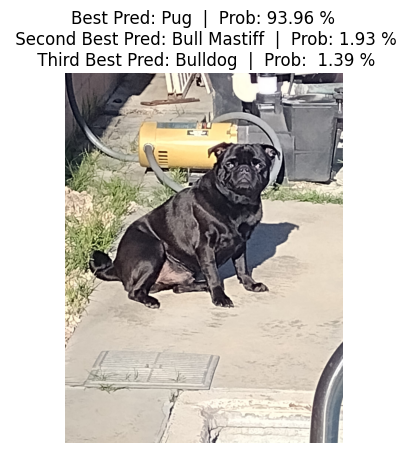

In [226]:
import requests

# Setup custom datapath
custom_image_path = data_path / "winston.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        print(f"Downloading {custom_image_path}...")
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=loaded_model,
                    image_path=custom_image_path,
                    class_names=class_names
                    )